In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import pickle

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [4]:
train.columns = ['ForecastId', 'Province_State', 'Country_Region', 'Date', 'ConfirmedCases', 'Fatalities']

In [5]:
train.head()

,ForecastId,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


In [6]:
test = test[test['Date'] > '2020-04-02']

In [7]:
china_agg = train[train['Country_Region'] == 'China'].groupby(['Country_Region','Date'])['ConfirmedCases','Fatalities'].sum().reset_index()

In [8]:
china_agg['Province_State'] = np.nan
china_agg['ForecastId'] = 0

In [9]:
china_agg.tail()

,Country_Region,Date,ConfirmedCases,Fatalities,Province_State,ForecastId
67,China,2020-03-29,82122.0,3304.0,NaN,0
68,China,2020-03-30,82198.0,3308.0,NaN,0
69,China,2020-03-31,82279.0,3309.0,NaN,0
70,China,2020-04-01,82361.0,3316.0,NaN,0
71,China,2020-04-02,82432.0,3322.0,NaN,0


In [10]:
train = train.append(china_agg)

In [11]:
master = train.append(test)

In [12]:
#master.groupby(['Country_Region','Province_State'])['Date'].min().reset_index().to_csv("lockdown_dates_1.csv",index=False)

In [13]:
master['Province_State'] = master['Province_State'].fillna('')

In [14]:
master['Country_State'] = master['Country_Region'].str.cat(master['Province_State'],sep=" ")

In [15]:
lockdown_dates = pd.read_csv("lockdown_dates.csv")

In [16]:
lockdown_dates['Country_State'] = lockdown_dates['Country_Region'].str.cat(lockdown_dates.Province_State.fillna(''),sep=" ")

In [17]:
def cc_model_poly(dataset,start_date,end_date,start_value,Country_State,knot_number):
    dataset = dataset[(dataset['Date'] >= start_date) & (dataset['Date'] <= end_date)]
    dataset['Date_diff'] = (((pd.to_datetime(dataset['Date']) - pd.to_datetime(start_date)).dt.days))
    dataset['Date_diff_p2'] = dataset['Date_diff']**2
    dataset['Date_diff_p3'] = dataset['Date_diff']**3
    input_columns = ['Date_diff','Date_diff_p2','Date_diff_p3']
    
    if len(dataset.dropna()) > 5:
        start_value = dataset['ConfirmedCases_inc'].values[0]
        dataset['ConfirmedCases_inc_use'] = dataset['ConfirmedCases_inc_sm']
        reg = LinearRegression().fit(dataset.dropna()[input_columns], dataset.dropna()['ConfirmedCases_inc_use'])
        dataset['ConfirmedCases_pred'] = reg.predict(dataset[input_columns])
#         print(reg.score(dataset.dropna()[input_columns], dataset.dropna()['ConfirmedCases_inc_use']))
#         print(reg.coef_, reg.intercept_)
        filename = 'cc_'+Country_State+'_'+knot_number+'.sav'
        pickle.dump(reg, open('model_objects/'+filename, 'wb'))
    else:
        print('..picking fallback cc model..')
        loaded_model = pickle.load(open('model_objects/cc_China Hubei'+'_'+knot_number+'.sav', 'rb'))
#         print(loaded_model.coef_, loaded_model.intercept_)
        dataset['ConfirmedCases_pred'] = loaded_model.predict(dataset[input_columns]) - loaded_model.intercept_ + start_value

#     outlier treatment for middle knot
    if knot_number == '2':
        cap_upper = dataset['ConfirmedCases_inc'].mean() + (dataset['ConfirmedCases_inc'].std())
        cap_lower = dataset['ConfirmedCases_inc'].mean() - (dataset['ConfirmedCases_inc'].std())
        dataset['ConfirmedCases_pred'] = dataset['ConfirmedCases_pred'].clip(lower=cap_lower, upper=cap_upper)
    
    dataset['ConfirmedCases_pred'][dataset['ConfirmedCases_pred'] < 0] = 0
    return(dataset)

In [18]:
def cc_model_exp(dataset,start_date,end_date,start_value,Country_State,knot_number):
    dataset = dataset[(dataset['Date'] >= start_date) & (dataset['Date'] <= end_date)]
    dataset['Date_diff'] = (((pd.to_datetime(dataset['Date']) - pd.to_datetime(start_date)).dt.days))
#     input_columns = [['Date_diff']]
    
    if len(dataset.dropna()) > 5:
        dataset['ConfirmedCases_inc_use'] = dataset['ConfirmedCases_inc_sm'] + 0.0001 # to avoid infinity values from log(0)
        reg = LinearRegression().fit(dataset.dropna()[['Date_diff']], np.log(dataset.dropna()['ConfirmedCases_inc_use']))
        dataset['ConfirmedCases_pred'] = np.exp(reg.predict(dataset[['Date_diff']]))
#         print(reg.score(dataset.dropna()[['Date_diff']], dataset.dropna()['ConfirmedCases_inc_use']))
#         print(reg.coef_, reg.intercept_)
        filename = 'cc_'+Country_State+'_'+knot_number+'.sav'
        pickle.dump(reg, open('model_objects/'+filename, 'wb'))
    else:
        print('..picking fallback cc model..')
        loaded_model = pickle.load(open('model_objects/cc_China Hubei'+'_'+knot_number+'.sav', 'rb'))
#         print(loaded_model.coef_, loaded_model.intercept_)
        dataset['ConfirmedCases_pred'] = np.exp(loaded_model.predict(dataset[['Date_diff']]) - loaded_model.intercept_ + np.log(start_value))

    return(dataset)

In [19]:
def fa_model_lnr(dataset,Country_State):
    dataset['ConfirmedCases_lagn'] = dataset['ConfirmedCases'].shift(periods=5)
    dataset['ConfirmedCases_pred_lagn'] = dataset['ConfirmedCases_pred'].shift(periods=5).fillna(0)
    
    if len(dataset.dropna()) > 10:
        reg = LinearRegression(fit_intercept=False).fit(dataset.dropna()[['ConfirmedCases_lagn']], dataset.dropna()['Fatalities'])
        dataset['Fatalities_pred'] = reg.predict(dataset[['ConfirmedCases_pred_lagn']])
#         print(reg.score(dataset.dropna()[['ConfirmedCases_lagn']], dataset.dropna()['Fatalities']))
#         print(reg.coef_, reg.intercept_)
        filename = 'fa_'+Country_State+'_'+'.sav'
        pickle.dump(reg, open('model_objects/'+filename, 'wb'))
    else:
        print('..picking fallback fa model..')
        loaded_model = pickle.load(open('model_objects/fa_China Hubei'+'_'+'.sav', 'rb'))
#         print(loaded_model.coef_, loaded_model.intercept_)
        dataset['Fatalities_pred'] = loaded_model.predict(dataset[['ConfirmedCases_pred_lagn']])

    return(dataset)

In [20]:
def cc_plot_outputs(dataset):
    fig = plt.figure()
    plt.ioff()
    fig.set_size_inches(18.5, 10.5)
    plt.plot(dataset['Date'], dataset['ConfirmedCases_inc'], marker='o', color='lightgreen')
    plt.plot(dataset['Date'], dataset['ConfirmedCases_pred'], color='r')
    fig.savefig('plots/cc/'+Country_State+'.jpg')
    plt.close(fig)

In [21]:
def fa_plot_outputs(dataset):
    fig = plt.figure()
    plt.ioff()
    fig.set_size_inches(18.5, 10.5)
    plt.plot(dataset['Date'], dataset['Fatalities'], marker='o', color='lightgreen')
    plt.plot(dataset['Date'], dataset['Fatalities_pred'], color='r')
    fig.savefig('plots/fa/'+Country_State+'.jpg')
    plt.close(fig)

running for: China Hubei
running for: Afghanistan 
..picking fallback cc model..
running for: Albania 
..picking fallback cc model..
running for: Algeria 
..picking fallback cc model..
running for: Andorra 
..picking fallback cc model..
running for: Angola 
..picking fallback cc model..
running for: Antigua and Barbuda 
..picking fallback cc model..
running for: Argentina 
..picking fallback cc model..
running for: Armenia 
..picking fallback cc model..
running for: Australia Australian Capital Territory
..picking fallback cc model..
running for: Australia New South Wales
..picking fallback cc model..
running for: Australia Northern Territory
..picking fallback cc model..
running for: Australia Queensland
..picking fallback cc model..
running for: Australia South Australia
..picking fallback cc model..
running for: Australia Tasmania
..picking fallback cc model..
running for: Australia Victoria
..picking fallback cc model..
running for: Australia Western Australia
..picking fallback cc

running for: Iraq 
..picking fallback cc model..
running for: Ireland 
..picking fallback cc model..
running for: Israel 
..picking fallback cc model..
running for: Italy 
..picking fallback cc model..
running for: Jamaica 
..picking fallback cc model..
running for: Japan 
..picking fallback cc model..
running for: Jordan 
..picking fallback cc model..
running for: Kazakhstan 
..picking fallback cc model..
running for: Kenya 
..picking fallback cc model..
running for: Korea, South 
..picking fallback cc model..
running for: Kosovo 
..picking fallback cc model..
..picking fallback cc model..
..picking fallback fa model..
running for: Kuwait 
..picking fallback cc model..
running for: Kyrgyzstan 
..picking fallback cc model..
running for: Laos 
..picking fallback cc model..
..picking fallback cc model..
running for: Latvia 
..picking fallback cc model..
running for: Lebanon 
..picking fallback cc model..
running for: Liberia 
..picking fallback cc model..
running for: Libya 
..picking fa

..picking fallback cc model..
running for: United Kingdom Anguilla
..picking fallback cc model..
exiting due to error
running for: United Kingdom Bermuda
..picking fallback cc model..
running for: United Kingdom British Virgin Islands
..picking fallback cc model..
exiting due to error
running for: United Kingdom Cayman Islands
..picking fallback cc model..
running for: United Kingdom Channel Islands
..picking fallback cc model..
running for: United Kingdom Gibraltar
..picking fallback cc model..
running for: United Kingdom Isle of Man
..picking fallback cc model..
running for: United Kingdom Montserrat
..picking fallback cc model..
running for: United Kingdom Turks and Caicos Islands
..picking fallback cc model..
exiting due to error
running for: United Kingdom 
..picking fallback cc model..
running for: Uruguay 
..picking fallback cc model..
running for: Uzbekistan 
..picking fallback cc model..
running for: Venezuela 
..picking fallback cc model..
running for: Vietnam 
..picking fall

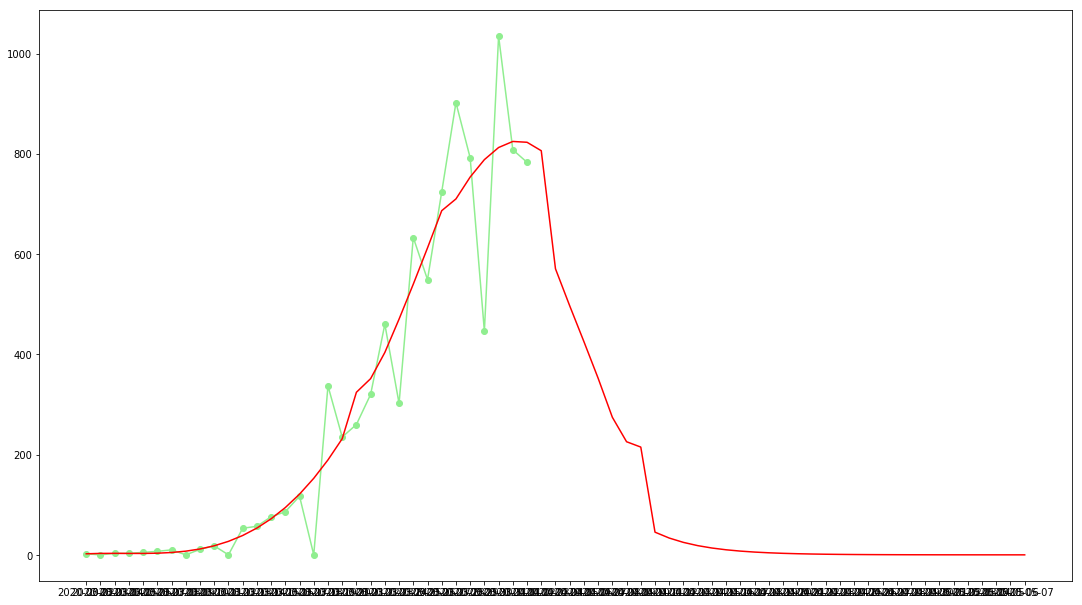

In [22]:
test_update = pd.DataFrame(columns = ['Province_State', 'Country_Region', 'Date', 'ConfirmedCases_pred' ,'Fatalities_pred'])
for Country_State in ['China Hubei'] + master['Country_State'].unique().tolist():
    print('running for: '+Country_State)
    master_use = master[master['Country_State'] == Country_State]
    st_dt = master_use['Date'][master_use['ConfirmedCases'] > 0].min()
    ld_dt = lockdown_dates['Lockdown_date'][lockdown_dates['Country_State'] == Country_State].values[0]
    mx_dt = master_use['Date'].max()
    master_use['ConfirmedCases_inc'] = master_use['ConfirmedCases'] - master_use['ConfirmedCases'].shift(periods=1).fillna(0)
    master_use['ConfirmedCases_inc_sm'] = master_use['ConfirmedCases_inc'].rolling(window=5,center=True,min_periods=1).mean()
    
    add_wdw = 3
    kt_1p = (pd.to_datetime(ld_dt)+dt.timedelta(days=14+add_wdw)).strftime("%Y-%m-%d")
    kt_1m = (pd.to_datetime(ld_dt)+dt.timedelta(days=14-add_wdw)).strftime("%Y-%m-%d")
    kt_2p = (pd.to_datetime(ld_dt)+dt.timedelta(days=28+add_wdw)).strftime("%Y-%m-%d")
    kt_2m = (pd.to_datetime(ld_dt)+dt.timedelta(days=28-add_wdw)).strftime("%Y-%m-%d")
    
    try:
        a = cc_model_poly(master_use, st_dt, kt_1p, 0, Country_State, '1')
        b = cc_model_poly(master_use, kt_1m, kt_2p, a.tail(1)['ConfirmedCases_pred'].values[0], Country_State, '2')
        c = cc_model_exp(master_use, kt_2m, mx_dt, b.tail(1)['ConfirmedCases_pred'].values[0], Country_State, '3')
        master_use = a.append(b).append(c)
        master_use_plt = master_use.groupby('Date')['ConfirmedCases_pred','ConfirmedCases_inc'].mean().reset_index()
        cc_plot_outputs(master_use_plt)
                
#         update dataset
        master_use['ConfirmedCases_pred'] = master_use['ConfirmedCases_inc'].combine_first(master_use['ConfirmedCases_pred'])
        master_use['ConfirmedCases_pred'] = master_use['ConfirmedCases_pred'].cumsum()
        
        master_use = fa_model_lnr(master_use, Country_State)
        fa_plot_outputs(master_use)
        
        test_use = master_use[master_use['Date'] >= '2020-03-26']
        test_update = test_update.append(test_use[['Province_State', 'Country_Region', 'Date', 'ConfirmedCases_pred', 'Fatalities_pred']])
        
    except:
        print('exiting due to error')
        pass

In [23]:
# #         update test dataset
#         tst_st_dt = master_use['Date'][(master_use['Date'] > '2020-04-02')].min()
#         last_cumval = master_use[(master_use['type'] == 'Train') & (master_use['Date'] < tst_st_dt)].tail(1)['ConfirmedCases'].values[0]
#         test_use = master_use[master_use['type'] == 'Test']
#         test_use['ConfirmedCases_pred'] = test_use['ConfirmedCases_pred'].cumsum() + last_cumval
#         test_update = test_update.append(test_use[['ForecastId', 'Province_State', 'Country_Region', 'Date', 'type', 'ConfirmedCases_pred']])